In [2]:
import numpy as np
import pandas as pd

import matplotlib.pylab as pylab
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)

params = {'legend.fontsize': 20,
          'figure.figsize': (8, 5),
         'axes.labelsize': 24,
         'axes.titlesize':16,
         'xtick.labelsize':18,
         'ytick.labelsize':18}
mpl.rc('font',family='Times New Roman')
pylab.rcParams.update(params)
cmap = plt.cm.viridis
count = 10
color = [cmap(round(i/count*cmap.N)) for i in range(count)]

In [3]:
# Read all data

dft = pd.read_csv('data/defect/dft_info.csv')
ad1 = pd.read_csv('data/defect/Adsorption_ethene_ethane.csv')
ad2 = pd.read_csv('data/defect/Adsorption_CO2_methanol.csv')
ad = pd.concat([ad1, ad2], ignore_index=True, sort=False)

temp = pd.read_csv('data/Data_S1.csv')
feature = temp[temp['molecule']=='ethane'][temp.columns[2:101]]
feature['MOF'] = temp[temp['molecule']=='ethane']['MOF']

df = pd.DataFrame()

df['MOF'] = [x.split('_')[0] for x in ad['mof']]
df['adsorbate'] = ad['ad']
df['conc'] = [float(x.split('_')[1]) if len(x.split('_')) == 2 else 0 for x in ad['conc']]
df['p'] = ad['p']
df['q'] = ad['q']

temp = dft[dft['conc']=='0']
temp['MOF'] = [x.split('_')[0] for x in temp['mof'] ] 
temp['MPDC'] = temp['max'].values
df = pd.merge(df,temp[['MOF','MPDC']],on='MOF')

molData=np.array([
    ['xe',131.293,289.7,58.4,0.008,164.87,161.2,3.96], 
    ['butane',58.1,449.8,39.5,0.3,280.1,146.7,4.68], 
    ['propene',42.1,436.9,51.7,0.2,254.8,150.6,4.50], 
    ['ethane',30.1,381.8,50.3,0.2,184.0,126.2,4.44], 
    ['propane',44.1,416.5,44.6,0.2,230.1,136.5,4.30], 
    ['CO2',44.0,295.9,71.8,0.2,317.4,204.9,3.3], 
    ['ethene',28.054,282.5,51.2,0.089,169.3,228,4.16], 
    ['methane',16.04,190.4,46.0,0.011,111.5,91,3.80],
    ['kr',83.798,209.4,55.0,0.005,119.6,115.6,3.6],
    ['methanol',32.04,513.4,82.2,0.556,337.85,175.6,3.6]])

df_mol = pd.DataFrame(data=molData, columns=["adsorbate", "Mw/gr.mol-1", "Tc/K", "Pc/bar", "w", "Tb/K", "Tf/K",'d'])

megnet = pd.read_csv('data/megnet_properties.csv')
df = pd.merge(df,megnet,on='MOF')
df = pd.merge(df,feature,on='MOF')

df = pd.merge(df,df_mol,on='adsorbate')



df['ratio'] = np.log10([ x['q']/df[(df['MOF']==x['MOF']) & (df['conc']==0) & (df['p']==x['p']) & (df['adsorbate']==x['adsorbate'])]['q'].values[0] for ndex,x in df.iterrows()])
df = df.replace([np.inf], 0.3)
df = df.replace([-np.inf], -0.3)

df['class'] = df['ratio']
df['class'] = df['class'].apply(lambda x: -1 if x < -0.1 else x)
df['class'] = df['class'].apply(lambda x: 0 if x > -0.1 and x < 0.1 else x)
df['class'] = df['class'].apply(lambda x: 1 if x > 0.1 else x)
df = df.dropna(axis=0)

df.to_csv('data/defect_data.csv')

# feature scale
print(len(df))
df_norm = df[df.columns[2:-2]]
df_norm = df_norm[df_norm['conc']<=df_norm['MPDC']]
print(len(df_norm))

df_norm = df_norm.astype(float)
df_norm = df_norm.loc[:, [len(np.unique(df_norm[x])) > 2 for x in df_norm.columns]]
df_norm = (df_norm-df_norm.min())/(df_norm.max()-df_norm.min())

df_norm = df_norm.dropna(axis=1)

/tmp/ipykernel_3240193/2771316591.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['MOF'] = [x.split('_')[0] for x in temp['mof'] ]
/tmp/ipykernel_3240193/2771316591.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['MPDC'] = temp['max'].values
/tmp/ipykernel_3240193/2771316591.py:47: RuntimeWarning: divide by zero encountered in log10
  df['ratio'] = np.log10([ x['q']/df[(df['MOF']==x['MOF']) & (df['conc']==0) & (df['p']==x['p']) & (df['adsorbate']==x['adsorbate'])]['q'].values[0] for ndex

7265
5397


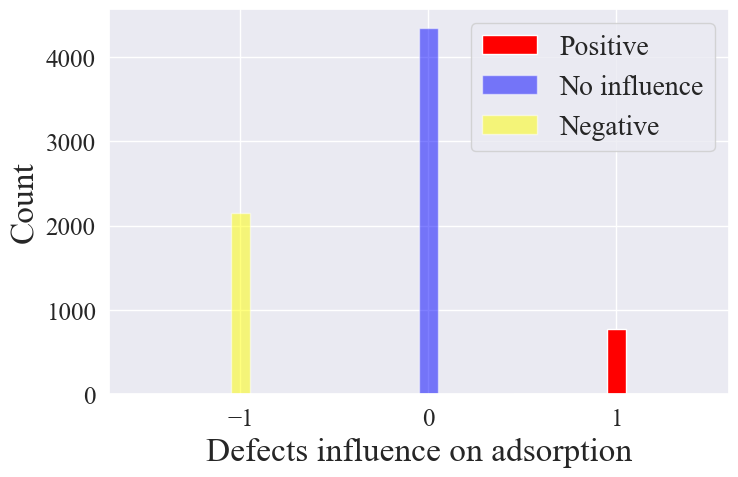

In [4]:
X_original = df[df.columns[0:-2]]
y_original = df[df.columns[-2]]
y_class_original = df[df.columns[-1]]

fig, ax = plt.subplots()
ax.hist(y_class_original[y_class_original==1], alpha=1.0, color='red', label='Positive',align='left')
ax.hist(y_class_original[y_class_original==0], alpha=0.5, color='blue', label='No influence',align='left')
ax.hist(y_class_original[y_class_original==-1], alpha=0.5, color='yellow', label='Negative',align='left')

ax.set_xlabel('Defects influence on adsorption')
ax.set_ylabel('Count')
plt.xticks([-1,0,1])
ax.legend()

fig.savefig('fig/defect_hist.jpg',dpi=500,bbox_inches='tight')

In [5]:
### classification train test split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[df.columns[4:-2]])
normalized_df = pd.DataFrame(normalized_data, columns=df[df.columns[4:-2]].columns)

selected_features = list(normalized_df.columns[0:7]) + ['d']

X_train_MOF, X_test_MOF, y_train_MOF, y_test_MOF = train_test_split(normalized_df[selected_features], df[df.columns[-1]], test_size=0.2, shuffle=False )

# X_train, X_test, y_train, y_test = train_test_split(normalized_df[normalized_df.columns[0:7]], df[df.columns[-1]], test_size=0.2, random_state=0, shuffle=True)
X_train = normalized_df[selected_features]
X_test = X_train
y_train = df[df.columns[-1]]
y_test = y_train


desired_order = ['ethene', 'ethane', 'propane', 'kr', 'butane', 'xe', 'propene'] 
df['sort'] = pd.Categorical(df['adsorbate'], categories=desired_order, ordered=True)
df = df.sort_values('sort')
df = df.drop(columns='sort')

scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[df.columns[4:-2]])
normalized_df = pd.DataFrame(normalized_data, columns=df[df.columns[4:-2]].columns)

X_train_adsorbate, X_test_adsorbate, y_train_adsorbate, y_test_adsorbate = train_test_split( normalized_df[selected_features], df[df.columns[-1]], test_size=0.2, shuffle=False)

Best Parameters:  {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  0.6531143120572204
Test Accuracy:  0.5712319339298004
[[338 151  19]
 [147 429  26]
 [186  94  63]]
[[1525  461  158]
 [ 876 3080  392]
 [ 228  141  404]]
Test Accuracy:  0.719029593943565


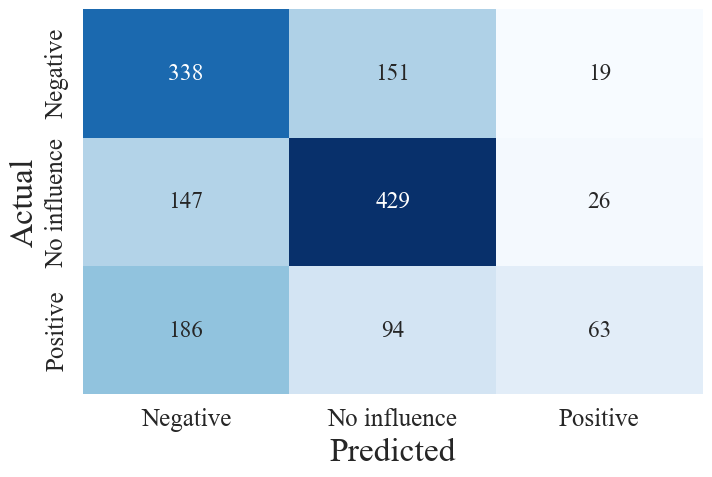

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Define the parameter grid for the grid search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}

# Create an SVM classifier
svm = SVC(decision_function_shape='ovo', class_weight='balanced', probability=True, random_state=0)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train_MOF, y_train_MOF)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_test_MOF_predicted = best_model.predict(X_test_MOF)
y_train_MOF_predicted = best_model.predict(X_train_MOF)
accuracy = accuracy_score(y_test_MOF, y_test_MOF_predicted)
print("Test Accuracy: ", accuracy)

y_all = np.concatenate((y_train_MOF_predicted, y_test_MOF_predicted))
y_true =  np.concatenate((y_train_MOF, y_test_MOF))
X_all = pd.concat([X_train_MOF, X_test_MOF], axis=0)

test_matrix = confusion_matrix(y_test_MOF, y_test_MOF_predicted)
print(test_matrix)
all_matrix = confusion_matrix(y_true, y_all)
print(all_matrix)

accuracy = accuracy_score(y_train_MOF, y_train_MOF_predicted)
print("Test Accuracy: ", accuracy)



# Create a figure and axes
fig, ax = plt.subplots()
label_name = ['Negative', 'No influence', 'Positive']
sns.heatmap(test_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_name, yticklabels=label_name, ax=ax)

# Set the axis labels and title
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Show the plot
plt.show()
fig.savefig('fig/defect_classification_MOF_confusion_matrix.jpg',dpi=500,bbox_inches='tight')

# Best Parameters:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}